# NSMC 네이버 영화리뷰 데이터 감성분석

> **진행순서**

    1. 리뷰데이터 EDA  
        - 데이터 개수
        - 라벨 비율
        - 평균 문장 길이 및 문장 길이 히스토그램

    2. 전처리 데이터클리닝(data cleaning)

        - 중복데이터 제거
        - 결측값 제거
        - 한글 제외한 글자 제거
        - 불용어 제거  
    
    3. 형태소 분류기를 이용하여 text tokenizing
        - okt : twitter데이터를 이용하여 학습시킨 형태소 분류기
        - mecab : 일본에서 만든 형태소분류기
        - komoran
        - kkma
        cf. pos 테그를 포함하여  
    
    4. text encoding
        - CounterVect
        - TfidfVect
        - Word2Vec  
        
    5. 모델학습  
        - SGD(ML)
        - SVM(ML)
        - 나이브베이즈(ML)
        - LSTM(DL)
        - BERT(DL)

- - -

### 필요 라이브러리 설치 및 분석 환경 정보

**[가상환경]**  
local에서 진행할 경우 아래 명령어로 가상환경 실행
> conda activate nsmc  

**[사용한 환경 정보]**  
파이썬 버전 : 3.7.13  
tensorflow 버전 : 2.10

In [53]:
import os 

# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
%matplotlib inline

# 한글폰트 불러오기
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import pickle
import re
import string

# preprocessing
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# modeling-ML
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# modeling-DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM

## EDA

In [96]:
# 네이버 영화리뷰 데이터 불러오기
train_df = pd.read_table(r"data\nsmc\ratings_train.txt")
test_df = pd.read_table(r"data\nsmc\ratings_test.txt")
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 개수 확인

In [87]:
# 데이터 개수
print(train_df.shape)
print(test_df.shape)

(150000, 3)
(50000, 3)


### 라벨 비율 확인

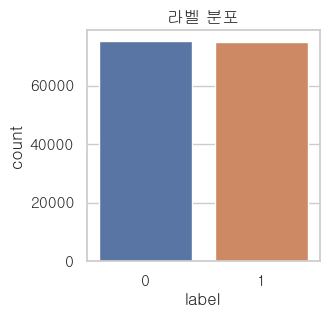

In [85]:
# 라벨의 비율 확인
plt.figure(figsize=(3,3))
sns.countplot(x='label',data=train_df)
plt.title('라벨 분포')
plt.show()

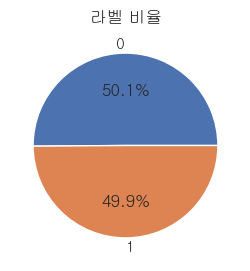

In [84]:
# 라벨 비율 확인
labels = ['0','1']
plt.figure(figsize=(3,3))
plt.title('라벨 비율')
plt.pie(train_df['label'].value_counts(), labels=labels, autopct='%.1f%%')
plt.show()

### 결측값 및 중복데이터 확인

In [94]:
# 결측값 확인
print('train data 결측값 수:', train_df['document'].isnull().sum())
print('test data 결측값 수:', test_df['document'].isnull().sum()) 

train data 결측값 수: 5
test data 결측값 수: 3


In [130]:
# 중복데이터 확인-train
print(train_df[train_df['document'].duplicated()].shape)
train_df[train_df['document'].duplicated()].head()

(3817, 3)


,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1


In [131]:
# 중복데이터 확인 - test
print(test_df[test_df['document'].duplicated()].shape)
test_df[test_df['document'].duplicated()].head()

(842, 3)


,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1


### 평균 리뷰 길이 및 리뷰길이 히스토그램

리뷰의 최대 길이 : 146
리뷰의 평균 길이 : 35.203453333333336


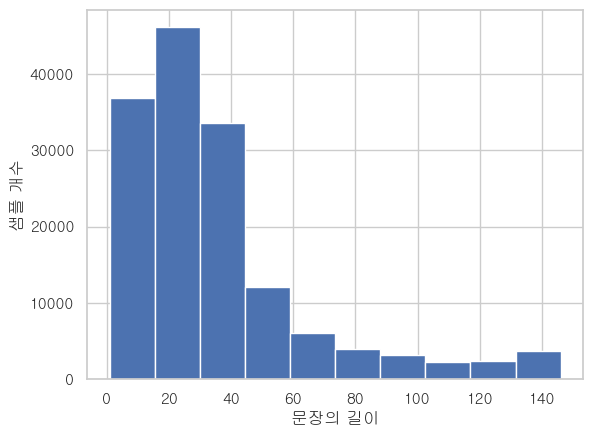

In [144]:
print('리뷰의 최대 길이 :', max([len(str(review)) for review in train_df['document']]))
print('리뷰의 평균 길이 :', np.mean([len(str(review)) for review in train_df['document']]))
plt.hist([len(str(review)) for review in train_df['document']])
plt.xlabel('문장의 길이')
plt.ylabel('샘플 개수')
plt.show()

리뷰 길이의 최대 값은 146글자이며 평균은 35글자이다.  
그러나 이후 전처리과정과 토크나이징을 처리를 한 후에 다시 확인해 볼 필요 있음.

## 전처리(Preprocessing)

In [ ]:
def preprocessing(train,test):
    # 중복값 처리
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    # 결측값 처리
    train.dropna(inplace=True)
    test.dropna(inplace=True)

    print('학습데이터 개수 :', train.shape[0])
    print('테스트데이터 개수 :', test.shape[0])